In [41]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [42]:

%matplotlib inline
from google.colab import files
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
print(tf.__version__)

2.9.2


In [43]:

imagepaths = []

for root, dirs, files in os.walk("mydrive/My Drive/DCGAN/", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): 
      imagepaths.append(path)

print(len(imagepaths)) 

1005


In [44]:
X = [] 
y = [] 


for path in imagepaths:
  img = cv2.imread(path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (28, 28))
  X.append(img)
  

  category = path.split("/")[3]
  label = int(category.split(" ")[1]) 
  y.append(label)


X = np.array(X, dtype="uint8")
#X = X.reshape(len(imagepaths), 232, 424, 3) # 
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  1005
Labels loaded:  1005
4 mydrive/My Drive/DCGAN/Class 4/11.png


In [45]:
ts = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=43)

In [46]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape

((804, 28, 28), (201, 28, 28))

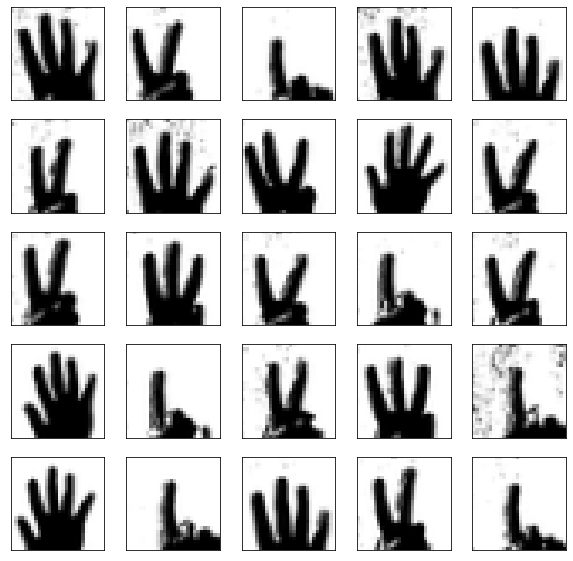

In [ ]:
# We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [47]:

batch_size = 32

def create_batch(x_train):
  dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
 
  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  return dataset

In [61]:


num_features = 100
 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding ="same", activation ="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_12 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 64)       204864    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                     

In [62]:

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_13 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 6272)            

In [50]:
import keras.backend as K
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [63]:

from keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.00005)
discriminator.compile(loss =wasserstein_loss, optimizer =optimizer, metrics=['accuracy'])
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])

gan.compile(loss =wasserstein_loss, optimizer =optimizer ,metrics=['accuracy'])

In [64]:
seed = tf.random.normal(shape =[batch_size, 100])
D_loss=[]
D_acc=[]
G_acc=[]
G_loss=[]
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 50):
	generator, discriminator = gan.layers
	for epoch in range(epochs):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# نویز  * 100
			# دادن نویز به شبکه مولد
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)

			# یک دسته از تصاویر واقعی و ساختگی می سازیم
			# از آن ها برای آموزش شبکه تفکیک کننده استفاده می کنیم
			X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
			y1 = tf.constant([[-1.]] * batch_size + [[1.]] * batch_size)
			discriminator.trainable = True
			#d_loss_real = discriminator.train_on_batch(x=X_batch, y=-np.ones((batch_size, 1)))
			d_loss,d_acc=discriminator.train_on_batch(X_fake_and_real, y1)
			D_loss.append(d_loss)
			D_acc.append(d_acc)
			# تصویر ساخته شده توسط شبکه مولد را با لیبل 1 به شبکه تفکیک کننده می دهیم
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			g_loss,g_acc=gan.train_on_batch(noise, y2)
			G_loss.append(g_loss)
			G_acc.append(g_acc)
	 		

		print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (epoch + 1, epochs, D_loss[-1], G_loss[-1]), 100*' ')
		if epoch % 5 == 0:
			samples = 10
			x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, num_features)))

			for k in range(samples):
				plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
				plt.imshow(x_fake[k, :, :, 0] * 127.5 + 127.5, cmap ='binary')


			plt.tight_layout()
			plt.show()

	#generate_and_save_images(generator, epochs, seed)



Epoch 1/50
epoch = 1/50, d_loss=-0.167, g_loss=0.367                                                                                                     
1/1 [==============================] - 0s 79ms/step


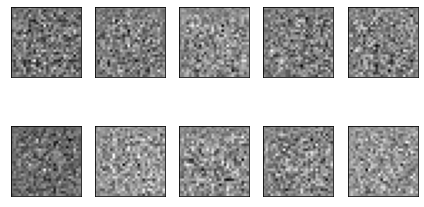


Epoch 2/50
epoch = 2/50, d_loss=-0.211, g_loss=0.334                                                                                                     

Epoch 3/50
epoch = 3/50, d_loss=-0.226, g_loss=0.404                                                                                                     

Epoch 4/50
epoch = 4/50, d_loss=-0.259, g_loss=0.550                                                                                                     

Epoch 5/50
epoch = 5/50, d_loss=-0.302, g_loss=0.660                                                                                                     

Epoch 6/50
epoch = 6/50, d_loss=-0.337, g_loss=0.711                                                                                                     
1/1 [==============================] - 0s 13ms/step


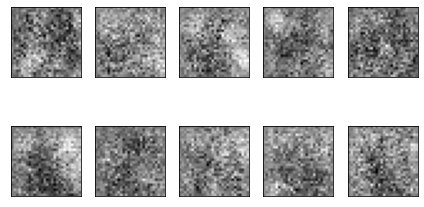


Epoch 7/50
epoch = 7/50, d_loss=-0.361, g_loss=0.625                                                                                                     

Epoch 8/50
epoch = 8/50, d_loss=-0.337, g_loss=0.654                                                                                                     

Epoch 9/50
epoch = 9/50, d_loss=-0.283, g_loss=0.710                                                                                                     

Epoch 10/50
epoch = 10/50, d_loss=-0.315, g_loss=0.618                                                                                                     

Epoch 11/50
epoch = 11/50, d_loss=-0.272, g_loss=0.682                                                                                                     
1/1 [==============================] - 0s 13ms/step


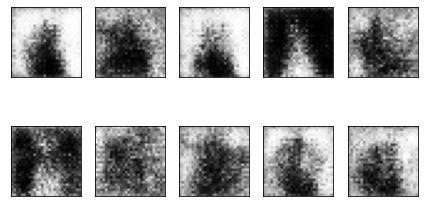


Epoch 12/50
epoch = 12/50, d_loss=-0.274, g_loss=0.544                                                                                                     

Epoch 13/50
epoch = 13/50, d_loss=-0.326, g_loss=0.541                                                                                                     

Epoch 14/50
epoch = 14/50, d_loss=-0.262, g_loss=0.654                                                                                                     

Epoch 15/50
epoch = 15/50, d_loss=-0.262, g_loss=0.514                                                                                                     

Epoch 16/50
epoch = 16/50, d_loss=-0.303, g_loss=0.453                                                                                                     
1/1 [==============================] - 0s 14ms/step


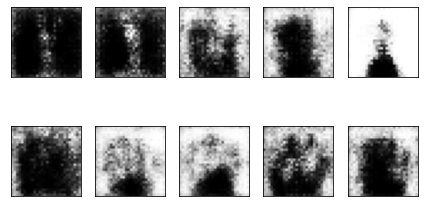


Epoch 17/50
epoch = 17/50, d_loss=-0.200, g_loss=0.420                                                                                                     

Epoch 18/50
epoch = 18/50, d_loss=-0.125, g_loss=0.596                                                                                                     

Epoch 19/50
epoch = 19/50, d_loss=-0.229, g_loss=0.452                                                                                                     

Epoch 20/50
epoch = 20/50, d_loss=-0.230, g_loss=0.390                                                                                                     

Epoch 21/50
epoch = 21/50, d_loss=-0.186, g_loss=0.555                                                                                                     
1/1 [==============================] - 0s 14ms/step


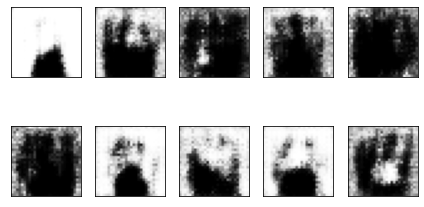


Epoch 22/50
epoch = 22/50, d_loss=-0.128, g_loss=0.501                                                                                                     

Epoch 23/50
epoch = 23/50, d_loss=-0.129, g_loss=0.748                                                                                                     

Epoch 24/50
epoch = 24/50, d_loss=-0.157, g_loss=0.638                                                                                                     

Epoch 25/50
epoch = 25/50, d_loss=-0.216, g_loss=0.428                                                                                                     

Epoch 26/50
epoch = 26/50, d_loss=-0.127, g_loss=0.466                                                                                                     
1/1 [==============================] - 0s 13ms/step


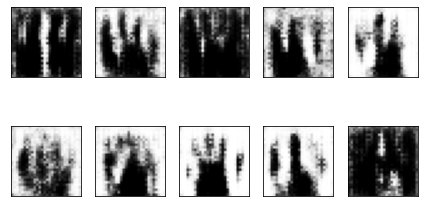


Epoch 27/50
epoch = 27/50, d_loss=-0.137, g_loss=0.404                                                                                                     

Epoch 28/50
epoch = 28/50, d_loss=-0.205, g_loss=0.281                                                                                                     

Epoch 29/50
epoch = 29/50, d_loss=-0.151, g_loss=0.373                                                                                                     

Epoch 30/50
epoch = 30/50, d_loss=-0.127, g_loss=0.269                                                                                                     

Epoch 31/50
epoch = 31/50, d_loss=-0.029, g_loss=0.272                                                                                                     
1/1 [==============================] - 0s 14ms/step


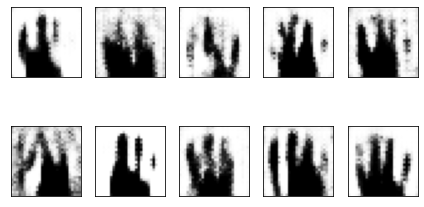


Epoch 32/50
epoch = 32/50, d_loss=-0.012, g_loss=0.092                                                                                                     

Epoch 33/50
epoch = 33/50, d_loss=0.001, g_loss=0.020                                                                                                     

Epoch 34/50
epoch = 34/50, d_loss=0.002, g_loss=0.001                                                                                                     

Epoch 35/50
epoch = 35/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 36/50
epoch = 36/50, d_loss=0.000, g_loss=0.000                                                                                                     
1/1 [==============================] - 0s 14ms/step


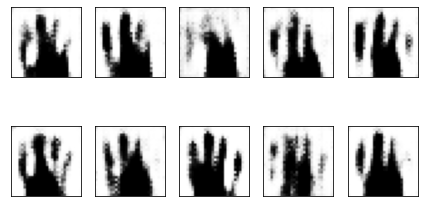


Epoch 37/50
epoch = 37/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 38/50
epoch = 38/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 39/50
epoch = 39/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 40/50
epoch = 40/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 41/50
epoch = 41/50, d_loss=0.000, g_loss=0.000                                                                                                     
1/1 [==============================] - 0s 15ms/step


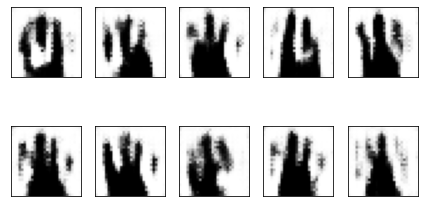


Epoch 42/50
epoch = 42/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 43/50
epoch = 43/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 44/50
epoch = 44/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 45/50
epoch = 45/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 46/50
epoch = 46/50, d_loss=0.000, g_loss=0.000                                                                                                     
1/1 [==============================] - 0s 14ms/step


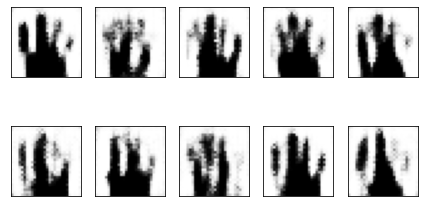


Epoch 47/50
epoch = 47/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 48/50
epoch = 48/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 49/50
epoch = 49/50, d_loss=0.000, g_loss=0.000                                                                                                     

Epoch 50/50
epoch = 50/50, d_loss=0.000, g_loss=0.000                                                                                                     


In [65]:

# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 50)

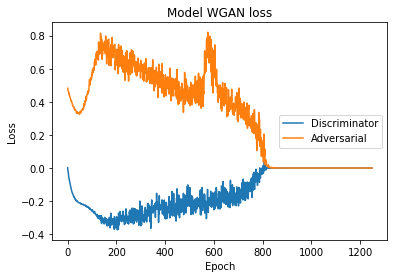

In [66]:
plt.plot(D_loss)
plt.plot(G_loss)
plt.title('Model WGAN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

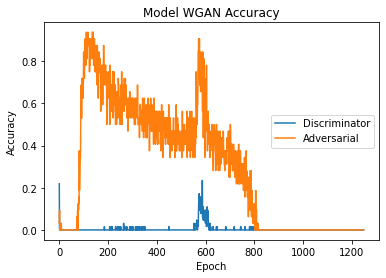

In [67]:
plt.plot(D_acc)
plt.plot(G_acc)
plt.title('Model WGAN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()